In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [4]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model, note that there are many typos in Kardy's paper for this eq'n
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, t, u, v, w = x_y_z_t_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v, 
            f1 * z + f2 * t + f3 *u + f4 * z * v + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * w + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    

# Cart on a pendulum
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=0, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, - ((M + m) * g * np.sin(w) + F * L1 * np.cos(w) + m * L1 ** 2 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 ** 2 * (M + m - m *np.cos(w) ** 2)),
            m * L1 ** 2 * np.sin(w) * y ** 2 + F * L1 + m * g * np.sin(w) * np.cos(
                w) / (L1 * (M + m - m * np.cos(w)) ** 2)]


# Infamous double pendulum problem (frictionless if k1=k2=0)
def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            #else:
            #    eval_string += ' - du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string, eval_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ np.transpose(full_coefficients), axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0 = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0, t)
x0 = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0, t)

# define hyperparameters
threshold = 1e-3

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5190, constraints m = 5200
          nnz(P) + nnz(A) = 60290
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 20000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-03   1.00e+00   3.37e+04   1.00e-01   6.42e-03s
 200   1.1206e-02   3.20e-05   4.16e-11   2.33e-03   3.57e-02s
 275   1.1206e-02   5.12e-06   1

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f101ecfc310>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.001))

0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
0.18239415378214807
0.18239415378214807
0.18239415378214807
0.18239415378214807
0.1825783070714697
0.1825783070714697
0.18239415378192325
0.18239415378192325
0.1823941537816985
0.1823941537816985
0.18239415378147367
0.18239415378147367
0.1823941537812489
0.1823941537812489
0.18239415378102405
0.18239415378102405
0.18239415378079923
0.18239415378079923
0.18239415378057447
0.18239415378057447
0.18239415378034965
0.18239415378034965
0.18239415378012486
0.18239415378012486
0.18239415377990006
0.18239415377990006
0.18239415378214807
0.18239415378214807
0.18257830707147177
0.18257830707147177
0.18239415377990006
0.18239415377990006
0.182394153777652
0.182394153777652
0.182394153775404
0.182394153775404
0.18239415377315601
0.18239415377315601
0.18239415377090795
0.18239415377090795
0.18239415376865994
0.18239415376865994
0.18239415376641188
0.

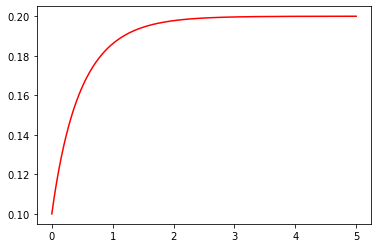

In [6]:
coef_index = 1
coefs = np.transpose(sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs)

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    print(eval(temp_string))
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')


In [7]:
# define parameters
r = 4
dt = 0.5
T = 20
t = np.arange(0, T + dt, dt)
# control input
F_train = -0.2 + 0.5 * np.sin(6 * t)
F_train[t > 16.0] = 0.0
#F_test = -1 + np.sin(t) + 3 * np.sin(2 * t)
F_test = -0.5 + 0.2 * np.sin(t) + 0.3 * np.sin(2 * t)
F_test[t > 2.0] = 0.0

x0 = [0.3, 0, 1, 0]
x_train = integrate.odeint(pendulum_on_cart_deriv, x0, t)
#x0 = [0.1, 0, 0.1, 0]
x0_test = [np.pi, 0, 0, 0]
x_test = integrate.odeint(pendulum_on_cart_deriv, x0_test, t)

# define hyperparameters
threshold = 0 # 1e-3

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x, y: sin(x) * sin(y), lambda x, y: sin(x) * cos(y),
                       lambda x, y: cos(x) * cos(y)]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x, y: 'sin(' + x + ')' + 'sin(' + y + ')', 
                          lambda x, y: 'sin(' + x + ')' + 'cos(' + y + ')',
                          lambda x, y: 'cos(' + x + ')' + 'cos(' + y + ')',
                          lambda x:'', lambda x:x] 
# library_function_names = [lambda x:'', lambda x:x, lambda x:x, lambda x:x,
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x:'', lambda x:x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t) #, u=F_train)
print(model.get_feature_names())

(39, 4)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 158576, constraints m = 158848
          nnz(P) + nnz(A) = 3202800
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.37e+02   1.00e+05   1.00e-01   3.85e-01s
 200   2.3829e-06   3.42e-03   1.04e-06   2.13e-05   2.50e+00s
 400   5.1480e-07   6.19e-03

/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 du[0]
17 du[1]
18 du[2]
19 du[3]
20 du[0]
21 du[1]
22 du[2]
23 du[3]
24 du[0]
25 du[1]
26 du[2]
27 du[3]
28 du[0]
29 du[1]
30 du[2]
31 du[3]
32 u[0]
33 u[0]
34 u[0]
35 u[0]
36 u[1]
37 u[1]
38 u[1]
39 u[1]
40 u[2]
41 u[2]
42 u[2]
43 u[2]
44 u[3]
45 u[3]
46 u[3]
47 u[3]
48 u[0]*du[0]
49 u[0]*du[1]
50 u[0]*du[2]
51 u[0]*du[3]
52 u[1]*du[0]
53 u[1]*du[1]
54 u[1]*du[2]
55 u[1]*du[3]
56 u[2]*du[0]
57 u[2]*du[1]
58 u[2]*du[2]
59 u[2]*du[3]
60 u[3]*du[0]
61 u[3]*du[1]
62 u[3]*du[2]
63 u[3]*du[3]
64 cos(u[0])
65 cos(u[0])
66 cos(u[0])
67 cos(u[0])
68 cos(u[1])
69 cos(u[1])
70 cos(u[1])
71 cos(u[1])
72 cos(u[2])
73 cos(u[2])
74 cos(u[2])
75 cos(u[2])
76 cos(u[3])
77 cos(u[3])
78 cos(u[3])
79 cos(u[3])
80 cos(u[0])*du[0]
81 cos(u[0])*du[1]
82 cos(u[0])*du[2]
83 cos(u[0])*du[3]
84 cos(u[1])*du[0]
85 cos(u[1])*du[1]
86 cos(u[1])*du[2]
87 cos(u[1])*du[3]
88 cos(u[2])*du[0]
89 cos(u[2])*du[1]
90 cos(u[2])*du[2]
91 cos(u[2])*du[3

[1.1352483016147108e-10, 1.1352482322257718e-10, 1.135247850586607e-10, 1.1352478852810766e-10]
[3.444887430870125e-11, 3.444888298231863e-11, 3.44489211462351e-11, 3.4448971453215904e-11]
[-5.924873786034013e-11, -5.924892867992249e-11, -5.924880204510874e-11, -5.924874653395751e-11]
[-1.4996239666720257e-10, -1.499623081963053e-10, -1.4996220931706716e-10, -1.4996245044363032e-10]
[1.9402361661757794e-11, 1.9402306150606563e-11, 1.940226798669009e-11, 1.9402368600651698e-11]
[-1.1434320504322137e-11, -1.143429795291695e-11, -1.1434355198791657e-11, -1.143440550577246e-11]
[7.803775681214375e-11, 7.803777415937851e-11, 7.803773426073857e-11, 7.803774293435595e-11]
[3.422958444465607e-11, 3.4229650364148156e-11, 3.422961740440211e-11, 3.422964515997773e-11]
[1.9907239051653036e-11, 1.990731017531555e-11, 1.990734486978507e-11, 1.990741425872411e-11]
[0.48002178309914484, 0.48002178309335986, 0.48002178311740207, 0.4800217831155141]
[333.40041541416934, 333.4004146487623, 333.4004147970

[2.5977680076505472e-11, 2.5977636708418572e-11, 2.5977756404338415e-11, 2.597766793344114e-11]
[7.416614024313706e-11, 7.416622697931086e-11, 7.416602054721722e-11, 7.416620269318219e-11]
[-1.1457496756905883e-10, -1.1457494154820669e-10, -1.1457499358991097e-10, -1.1457498144684664e-10]
[-4.45336181126299e-11, -4.4533569540372575e-11, -4.453346025279359e-11, -4.4533656276546374e-11]
[1.2645322289284167e-11, 1.2645077693274054e-11, 1.2645171368341757e-11, 1.2645299737878979e-11]
[1.5384464535639353e-10, 1.538447702564838e-10, 1.5384475984814294e-10, 1.5384477372593075e-10]
[-33235.07415224328, -33235.07407543241, -33235.074090205926, -33235.074108298955]
[-20.261831144344946, -20.261831157418797, -20.26183115507167, -20.26183115467208]
[15.100684242848194, 15.100684261812967, 15.100684266256511, 15.100684253627378]
[-6.312612841918878, -6.312612842746926, -6.3126128448326755, -6.312612838719746]
[6.3474017708564645e-12, 6.34726125825491e-12, 6.347436465325984e-12, 6.347186665145443e-1

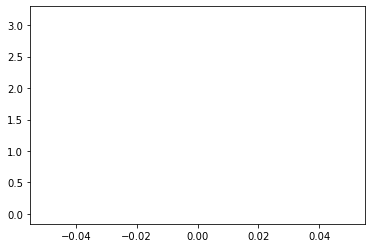

In [8]:
coef_index = 0
r = 4
coefs = np.transpose(sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs)

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = [np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 20)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
#plt.plot(t, integrate.odeint(pendulum_on_cart_deriv, u0, t), 'r')
plt.plot(sol.t, sol.u, 'k--')
print(sol)

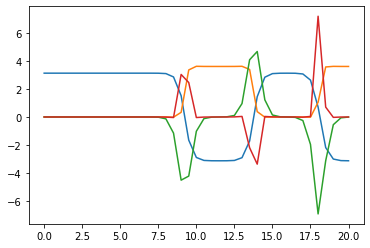

In [9]:
plt.plot(t, x_test)

In [10]:
sol.u

[array([3.14159265, 0.        , 0.        , 0.        ])]